# To do:





In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
# MAY NEED ADJUSTING DEPEDNING ON DEVICE/OS RUNNING
# data = pd.read_csv("../../Data/PAUS_866.csv")
# data['band'] = data['band'].str.slice(start=2).astype(int)
# Converts 'band' column from type string to int

data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")

In [4]:
# data.columns.values

In [5]:
lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
    file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
elif os.environ['NAME'] == 'LaNaranjaDos':
    file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
else: raise Exception('Device not configured for hdf5 data load')

LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

# SED with LD^2 (log scale)

In [6]:
#CUT
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 
data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]

lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
z_photos = data_sample['zb']


/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/andrew/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


wl bin step = 7.42
wl bin step = 6.80
wl bin step = 6.23
wl bin step = 5.79
wl bin step = 5.37
wl bin step = 5.04
wl bin step = 4.71
wl bin step = 4.43
Save figure? (y/n)


/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


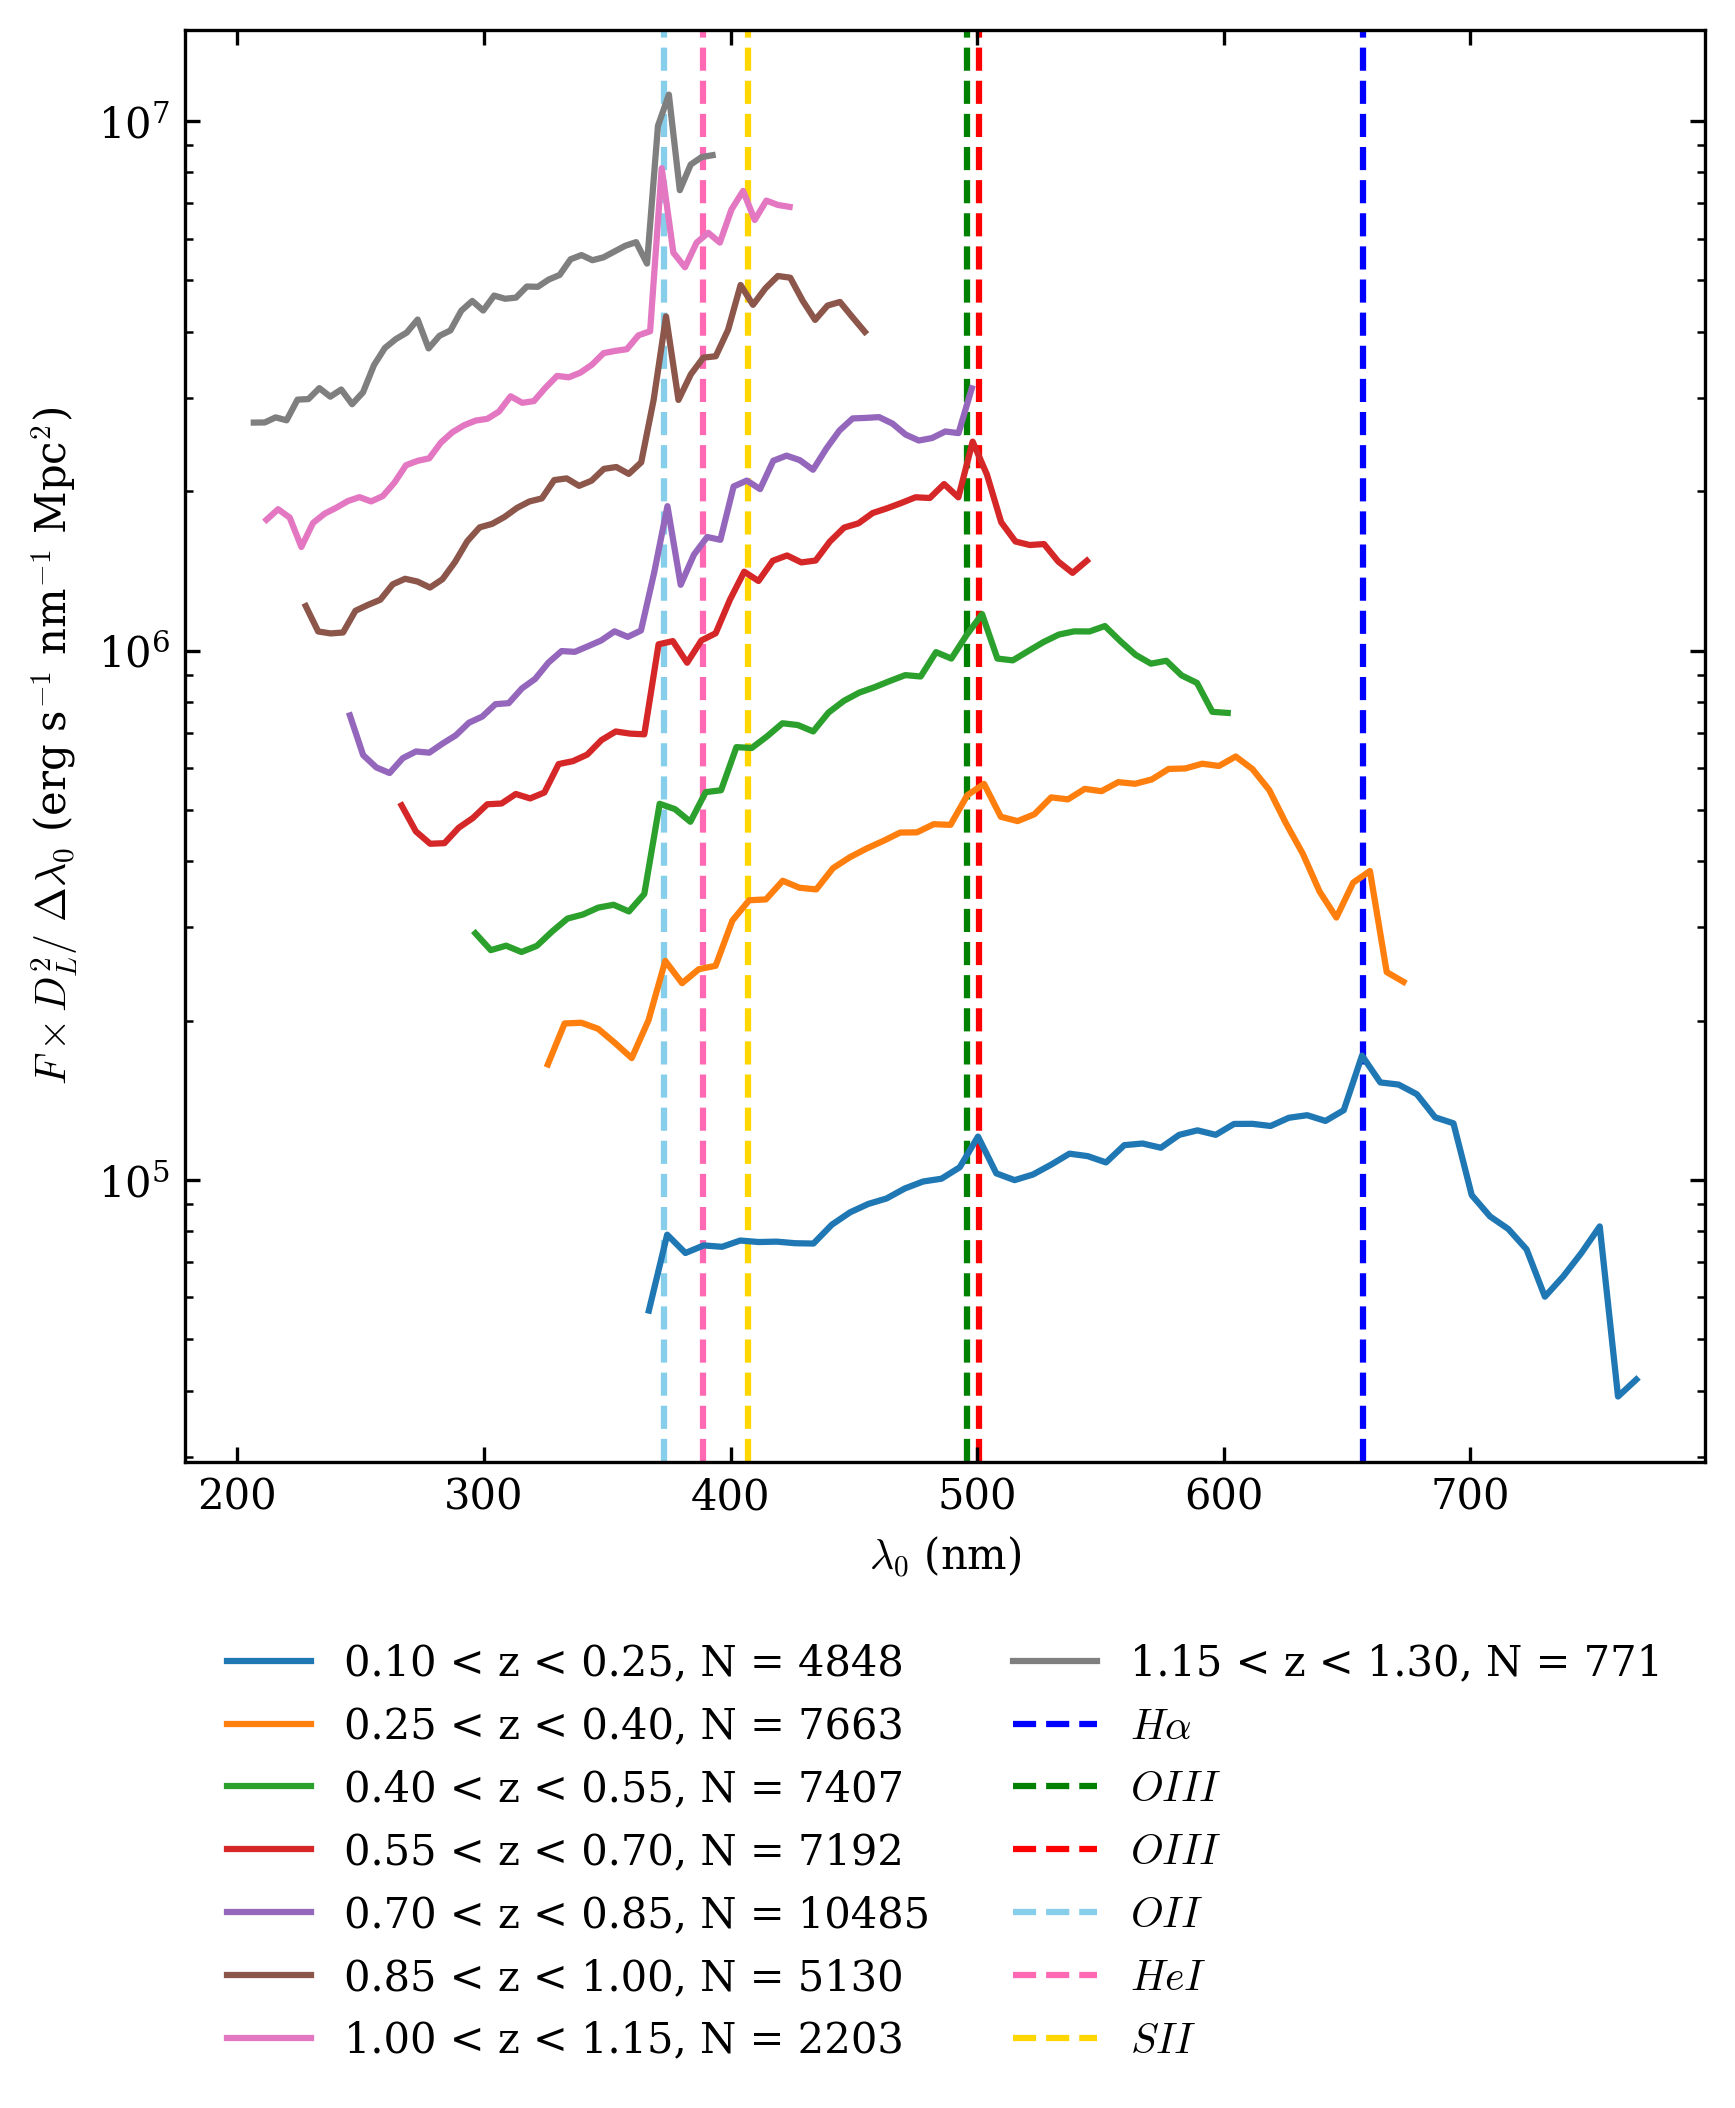

In [7]:
# bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
max_factor = 7.25
factor = 1/max_factor*latex_textwidth/72
fig = plt.figure(figsize=(7.5*factor,max_factor*factor),dpi=300)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(band_obsframe.min(),band_obsframe.max())

increments = np.linspace(90,150,len(bins))

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])
# band_bins = np.arange(200,860,band_bin_incs[ind])

for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
    print("wl bin step = {:3.2f}".format(step))
#     print(band_bins)
    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
#     print(lamb_sample.shape,flux_sample.shape,lum_dist_sample.shape)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
# Pre-changed
#     binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
# #     print (binned_means)
    
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl
    
    
    binned_means = [np.nanmedian(flux_sample[digitized == i]/130*(1+z_samp[digitized == i])*lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects),zorder=10) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
colours = ['blue','green','red','skyblue','hotpink','gold','black','white']
for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],label=line[1],color=colours[i],linestyle='--',zorder=1)

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F \times D_L^2 /\ \Delta\lambda_{0}$ (erg s$^{-1}$ nm$^{-1}$ Mpc$^2$)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,frameon=False)

plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
fixed_aspect_ratio(1)

custom_SAVEFIG(filetag='SED_LD')

plt.show()


# SED without LD^2 (lin scale)

/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Save figure? (y/n)


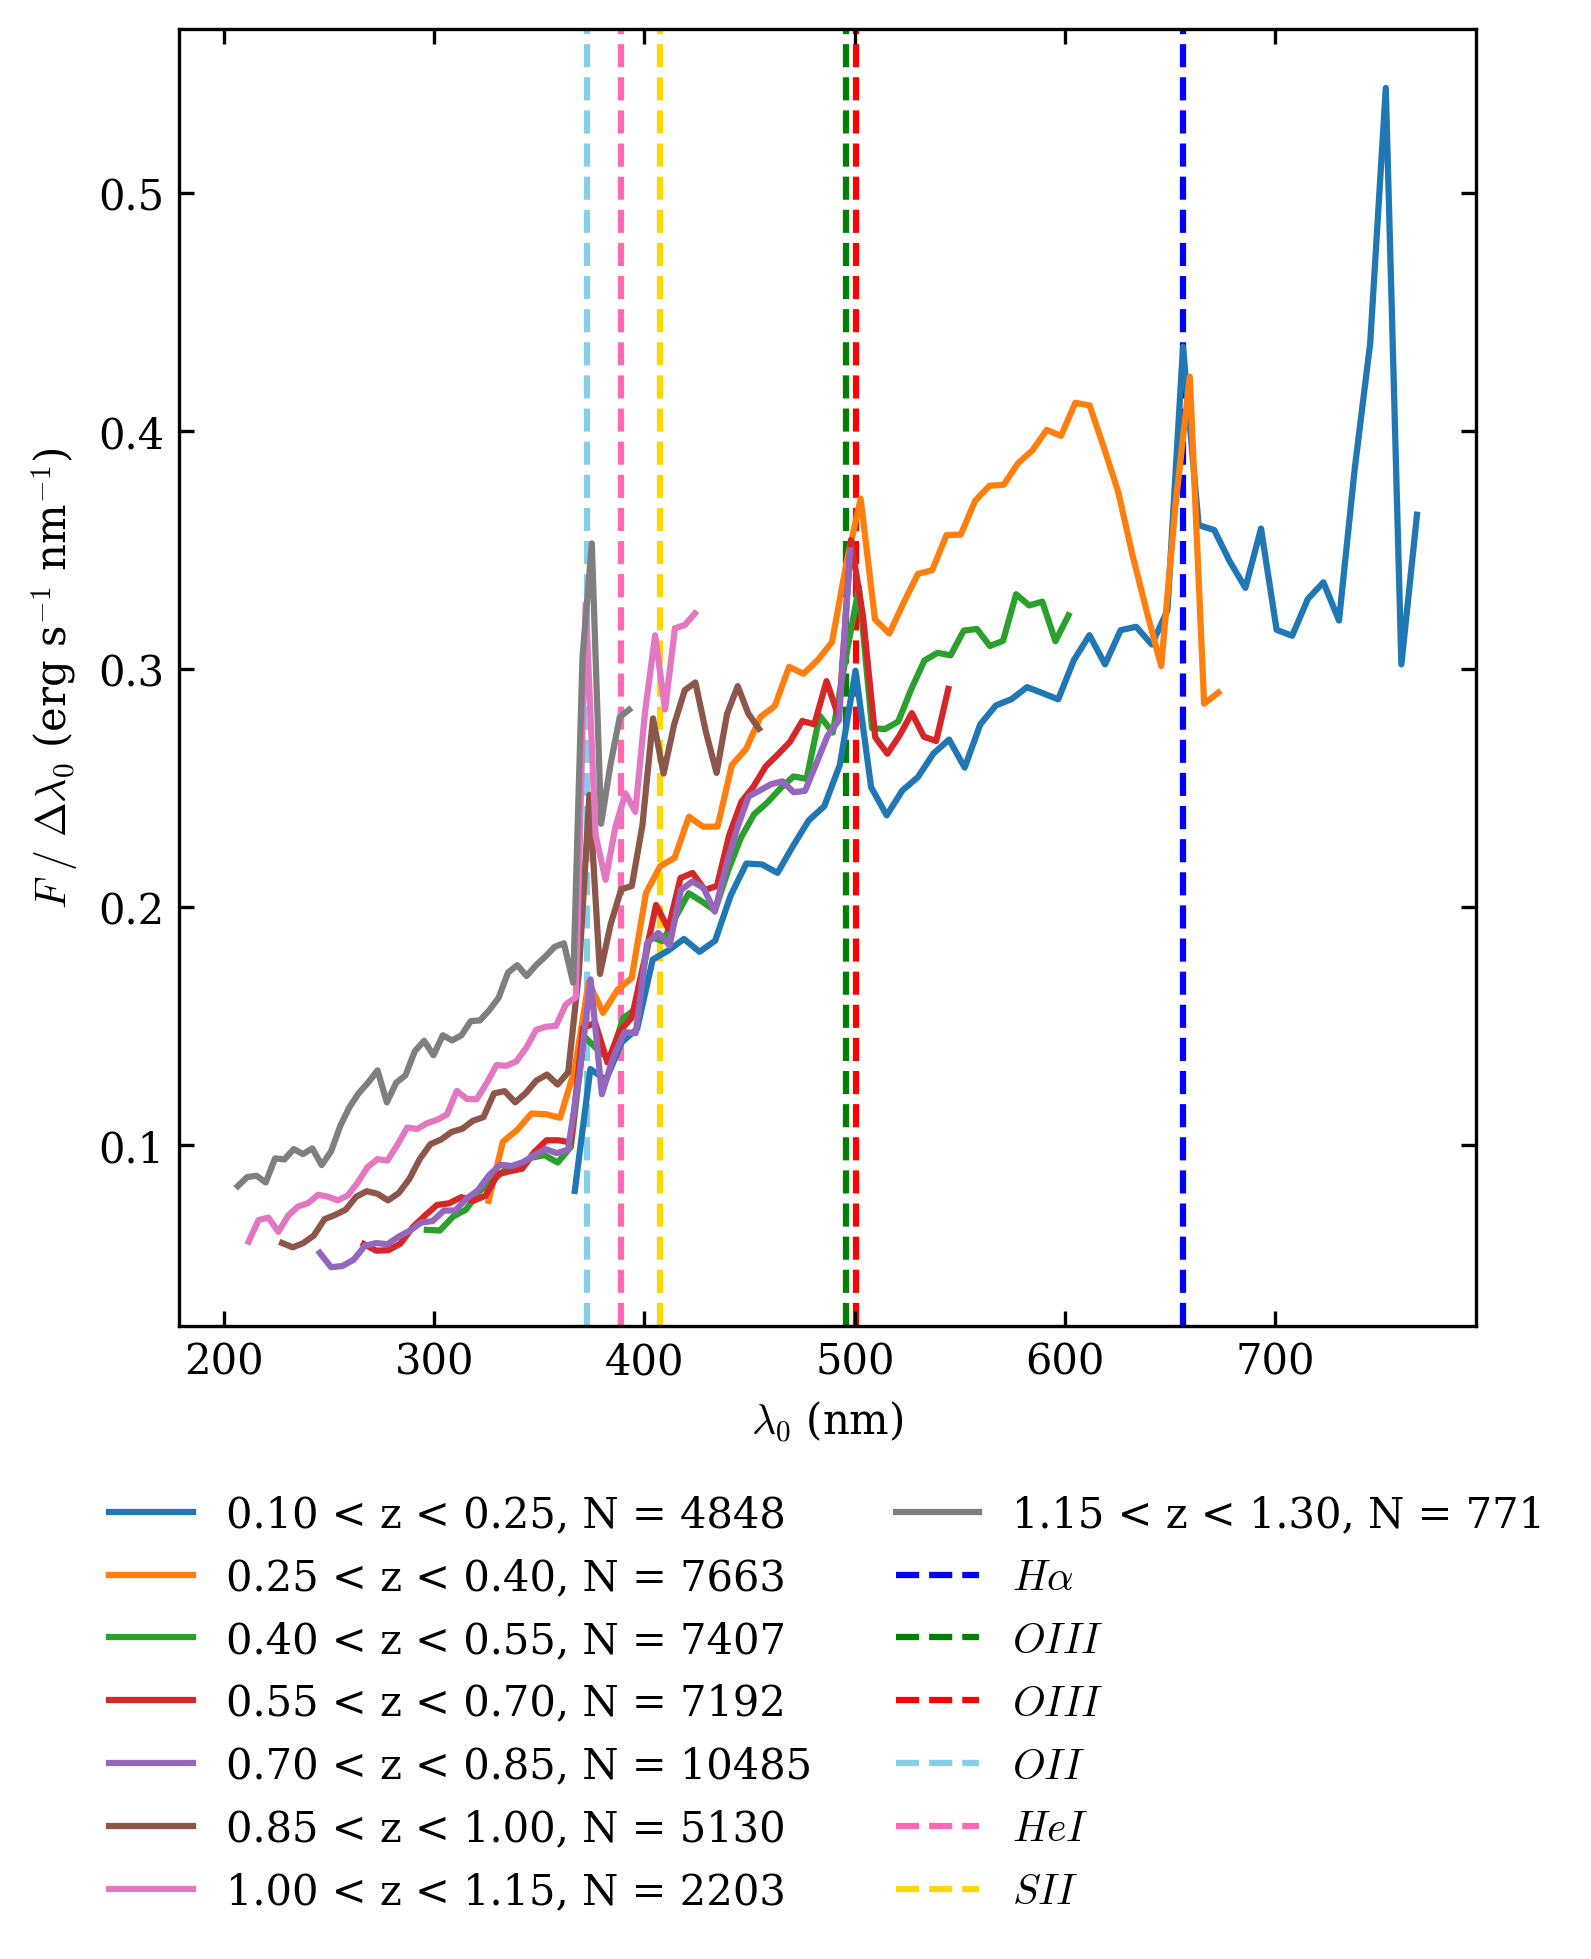

In [8]:
# bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

factor = 1/8.5 * latex_textwidth/72

fig = plt.figure(figsize=(7.5*factor,8.5*factor),dpi=300)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)


increments = np.linspace(90,150,len(bins))

all_means = []


for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
#     print(z_samp)
#     print(z_samp.size,flux_sample.size,z_photos.size)
    lum_dist_sample = luminosity_distances[truth_table].flatten()

    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
    #Pre- broken
#     binned_means = [np.nanmedian(flux_sample[digitized == i]) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl


    binned_means = [np.nanmedian(flux_sample[digitized == i]/130*(1+z_samp[digitized == i])) for i in range(1,len(band_bins))]
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects),zorder=10) #flux(in AB mags)/500 band wl
    

                                 
        

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
colours = ['blue','green','red','skyblue','hotpink','gold','black','white']
for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],label=line[1],color=colours[i],linestyle='--',zorder=1)

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F\ /\ \Delta\lambda_0$ (erg s$^{-1}$ nm$^{-1}$)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,frameon=False)
fixed_aspect_ratio(1)
custom_SAVEFIG(filetag='SED_LD')

# plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
plt.show()


# PAUS CDF

/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]


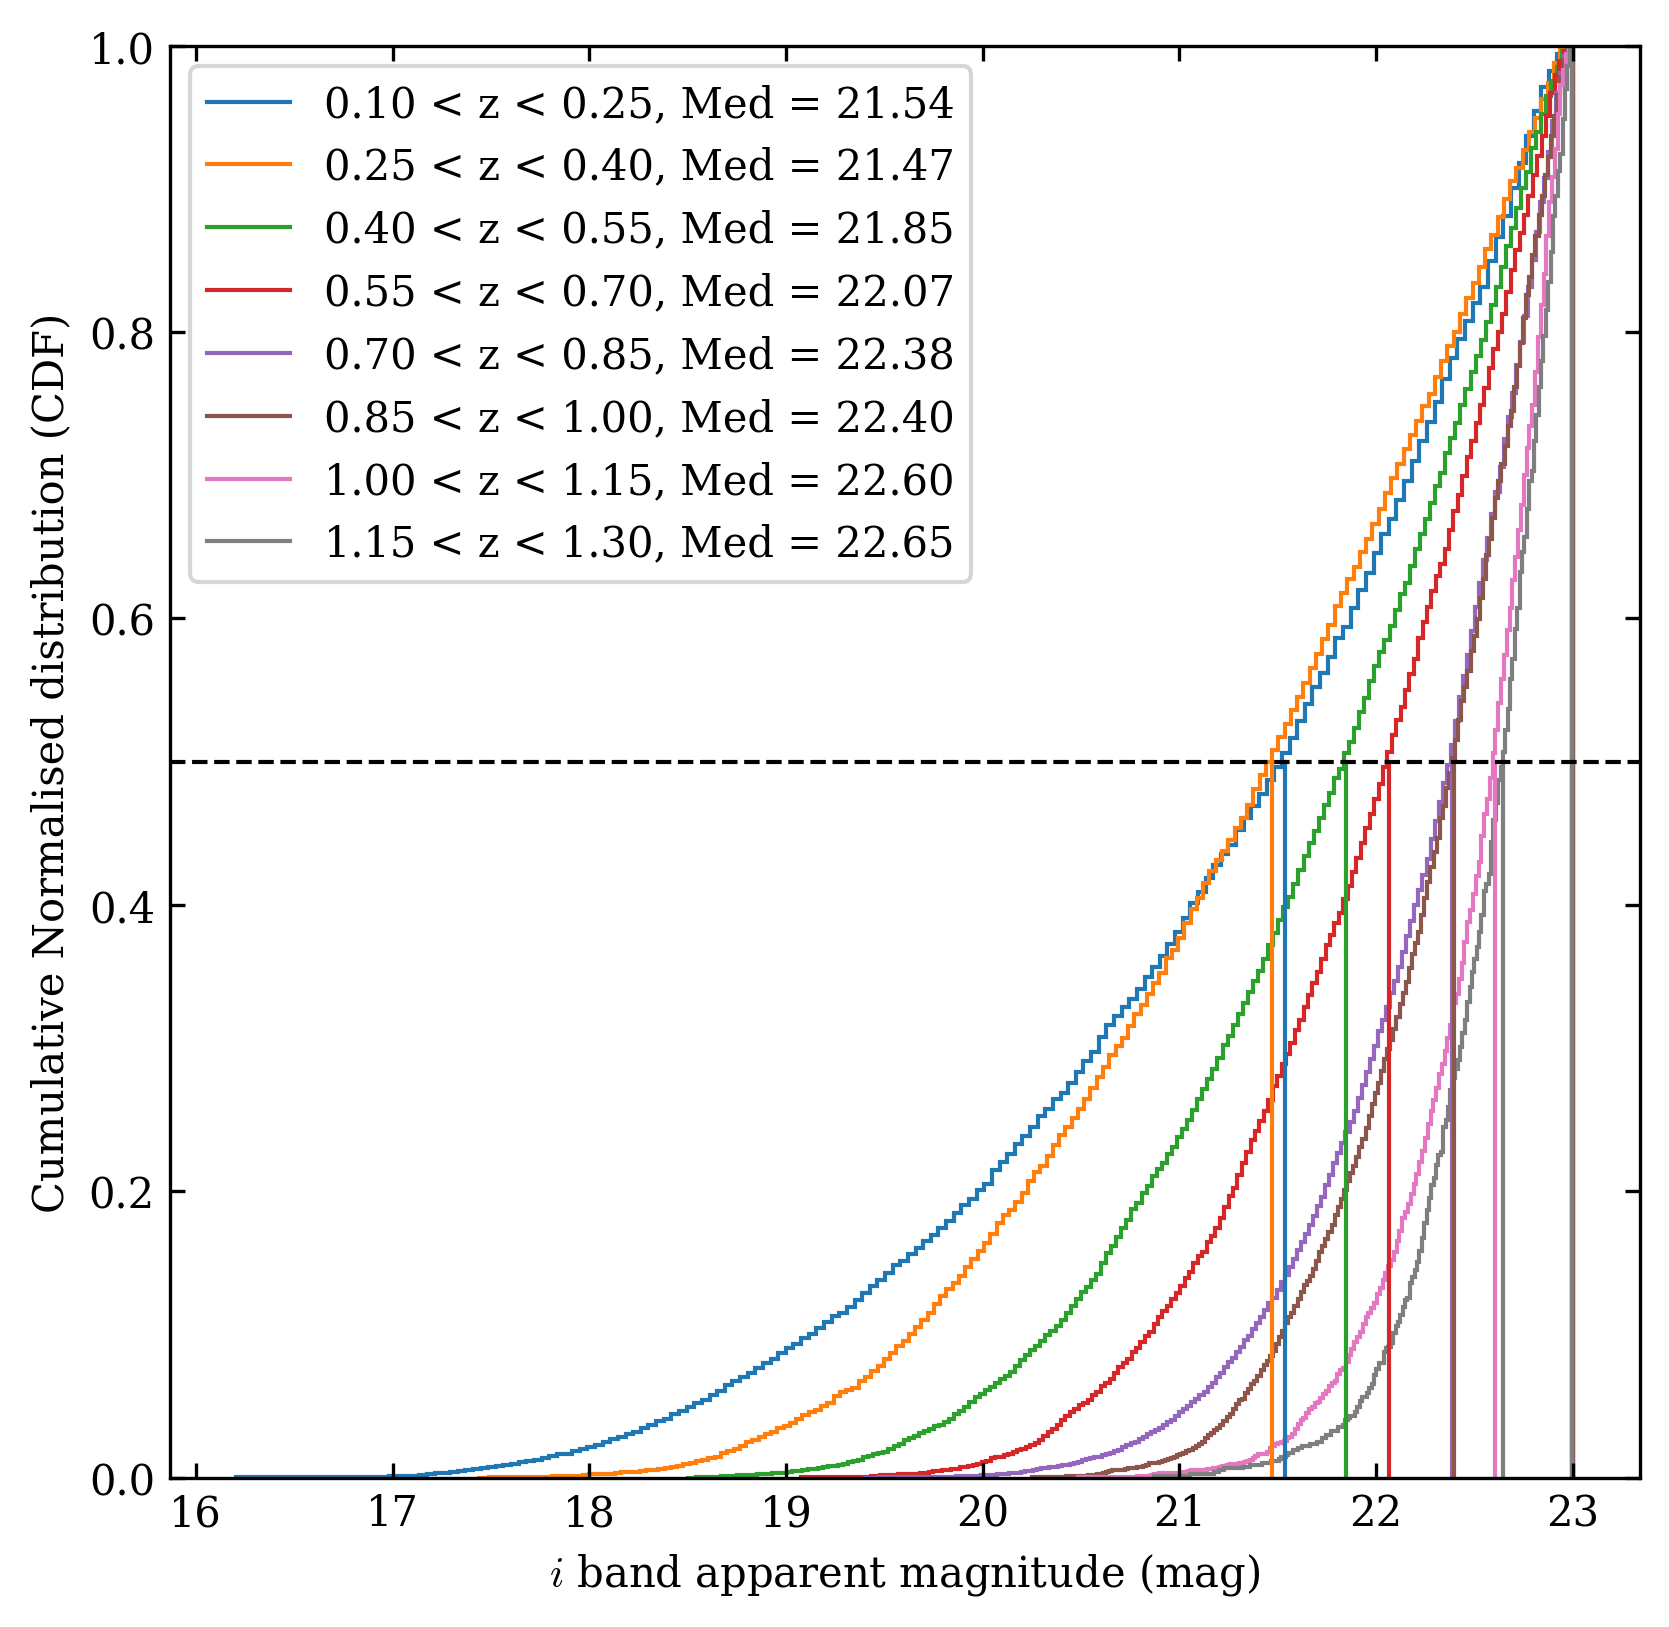

In [9]:
factor = latex_textwidth/72
plt.figure(figsize=(1*factor,1*factor),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

increments = np.linspace(90,150,len(bins))
for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)
    
#     lamb_sample = band_obsframe[truth_table].flatten()
    
    iband_mags = data_sample.loc[truth_table,'i_auto']
    N_objects = iband_mags.size
    median = np.median(iband_mags)
#     digitized = np.digitize(lamb_sample,band_bins)
#     binned_means = [np.nanmedian(iband_mags[digitized == i]) for i in range(1,len(band_bins))]
    hist = plt.hist(iband_mags,175,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
plt.xlabel('$i$ band apparent magnitude (mag)')
plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend()
# custom_SAVEFIG('PAUS_CDF')
plt.show()
    

# MOCK CDF

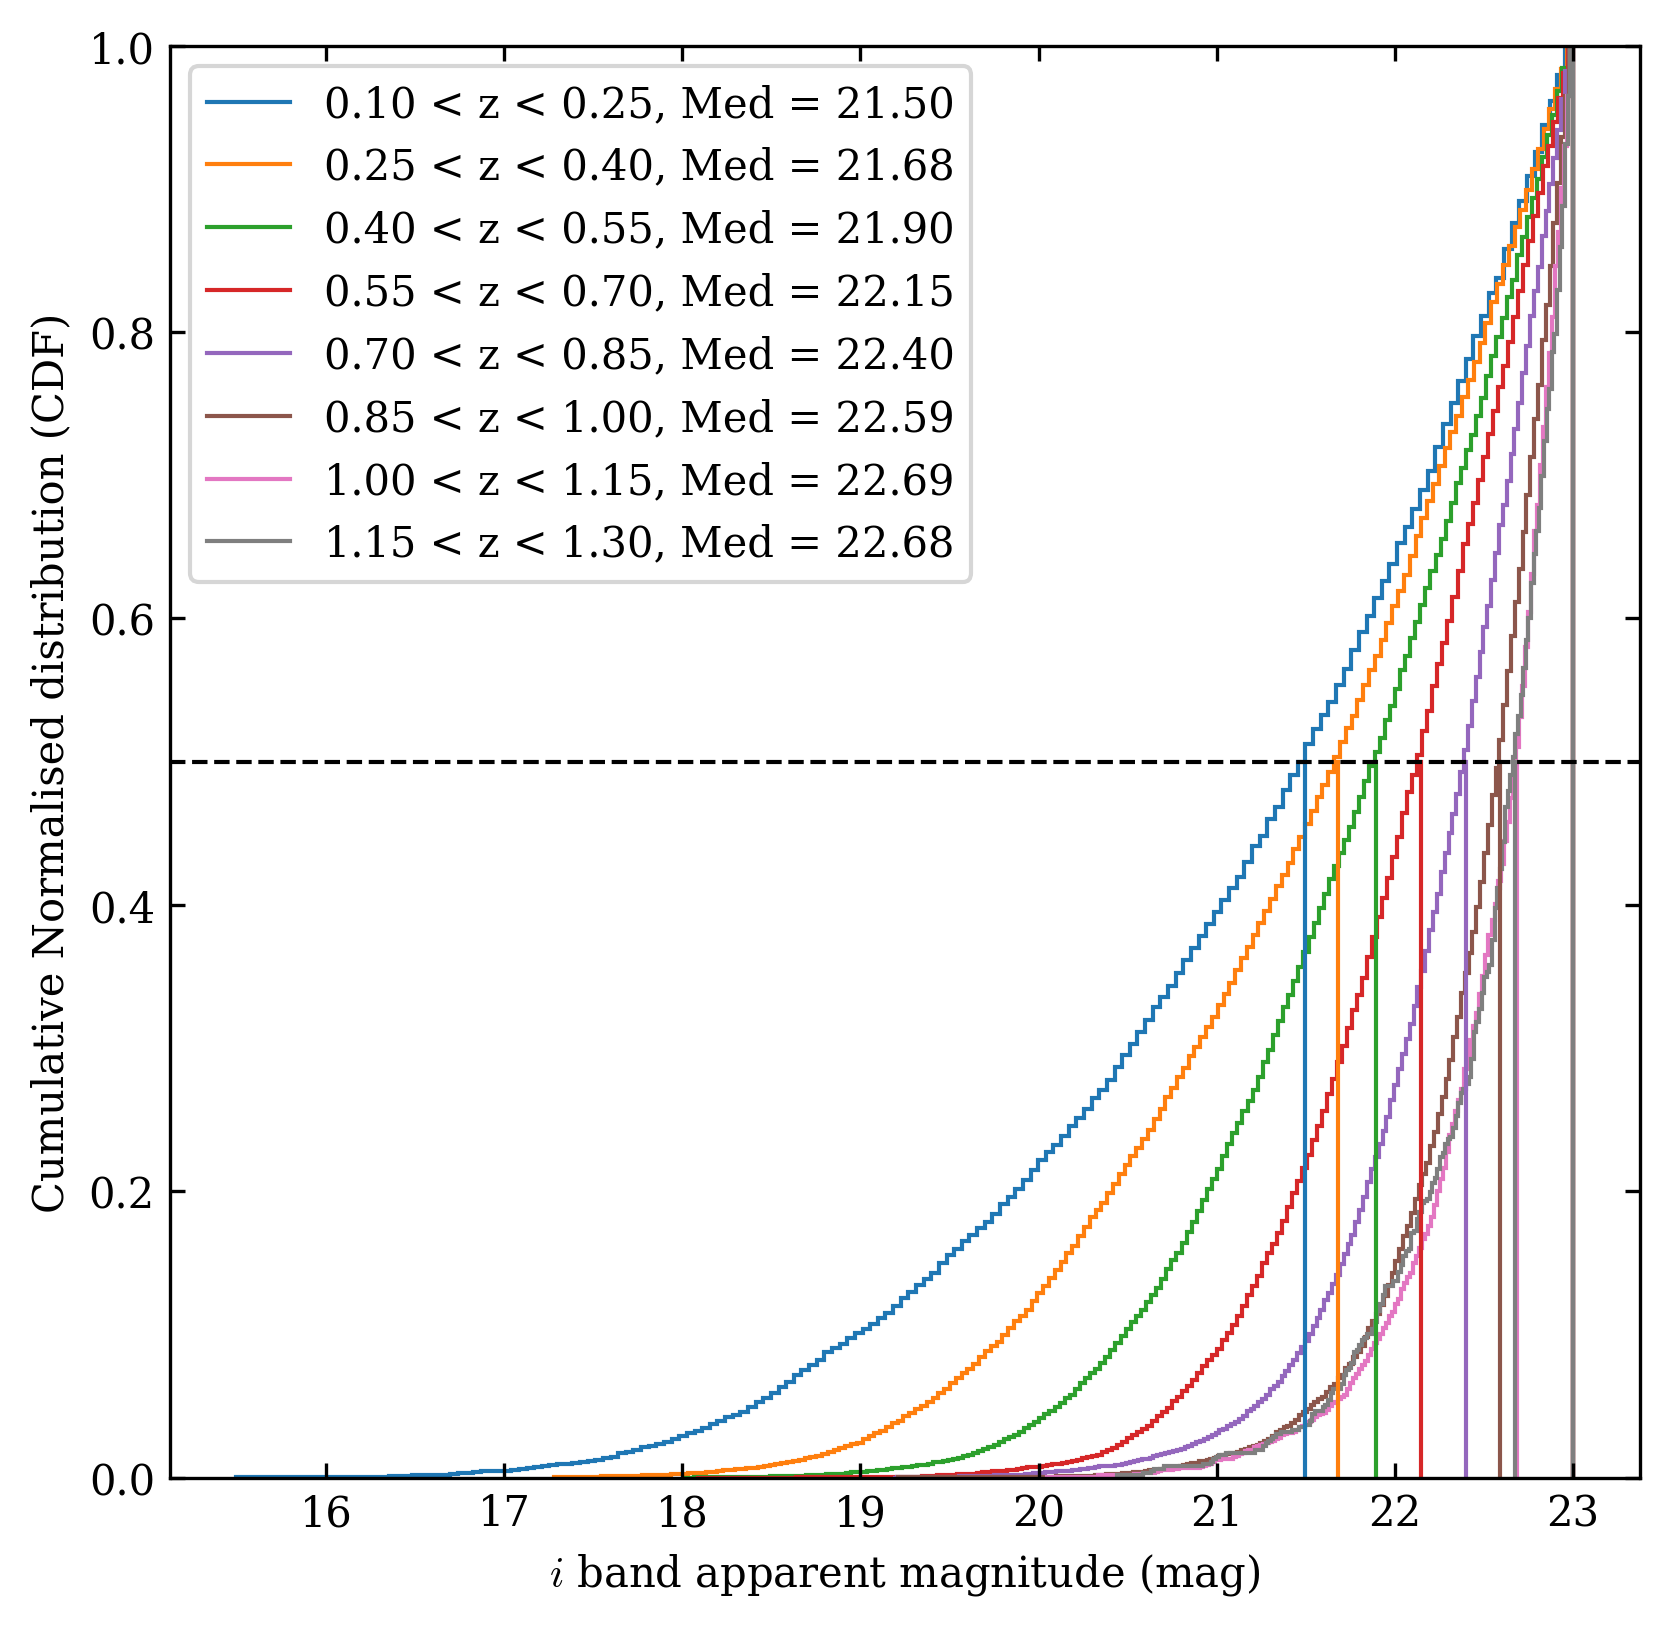

In [10]:
# LC_DATA_PHOTOM.visit(lambda x: print(x))
imags = np.array(LC_DATA_CORE['Data/appMio_tot_ext'])
zs = np.array(LC_DATA_CORE['Data/z_obs'])
LC_ras = np.array(LC_DATA_CORE['Data/ra'])
LC_decs = np.array(LC_DATA_CORE['Data/dec'])

mask = (imags<23) & (LC_ras < np.median(LC_ras)+1) & (LC_ras > np.median(LC_ras)-1) & (LC_decs < np.median(LC_decs)+0.5) & (LC_decs > np.median(LC_decs)-0.5)

zs = zs[mask]
imags = imags[mask]

# print(zs.min(),zs.max())

plt.figure(figsize=(1*factor,1*factor),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

for ind,z_bin in enumerate(bins):
    
    truth_table = (zs >= z_bin[0]) & (zs <= z_bin[1]) 
    
    iband_mags = imags[truth_table]
    N_objects = iband_mags.size
    median = np.median(iband_mags)

    hist = plt.hist(iband_mags,175,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
plt.xlabel('$i$ band apparent magnitude (mag)')
plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend(loc='upper left')
# custom_SAVEFIG('MOCK_SUBSECTION_CDF')
plt.show()

# Combined

/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]


Save figure? (y/n)


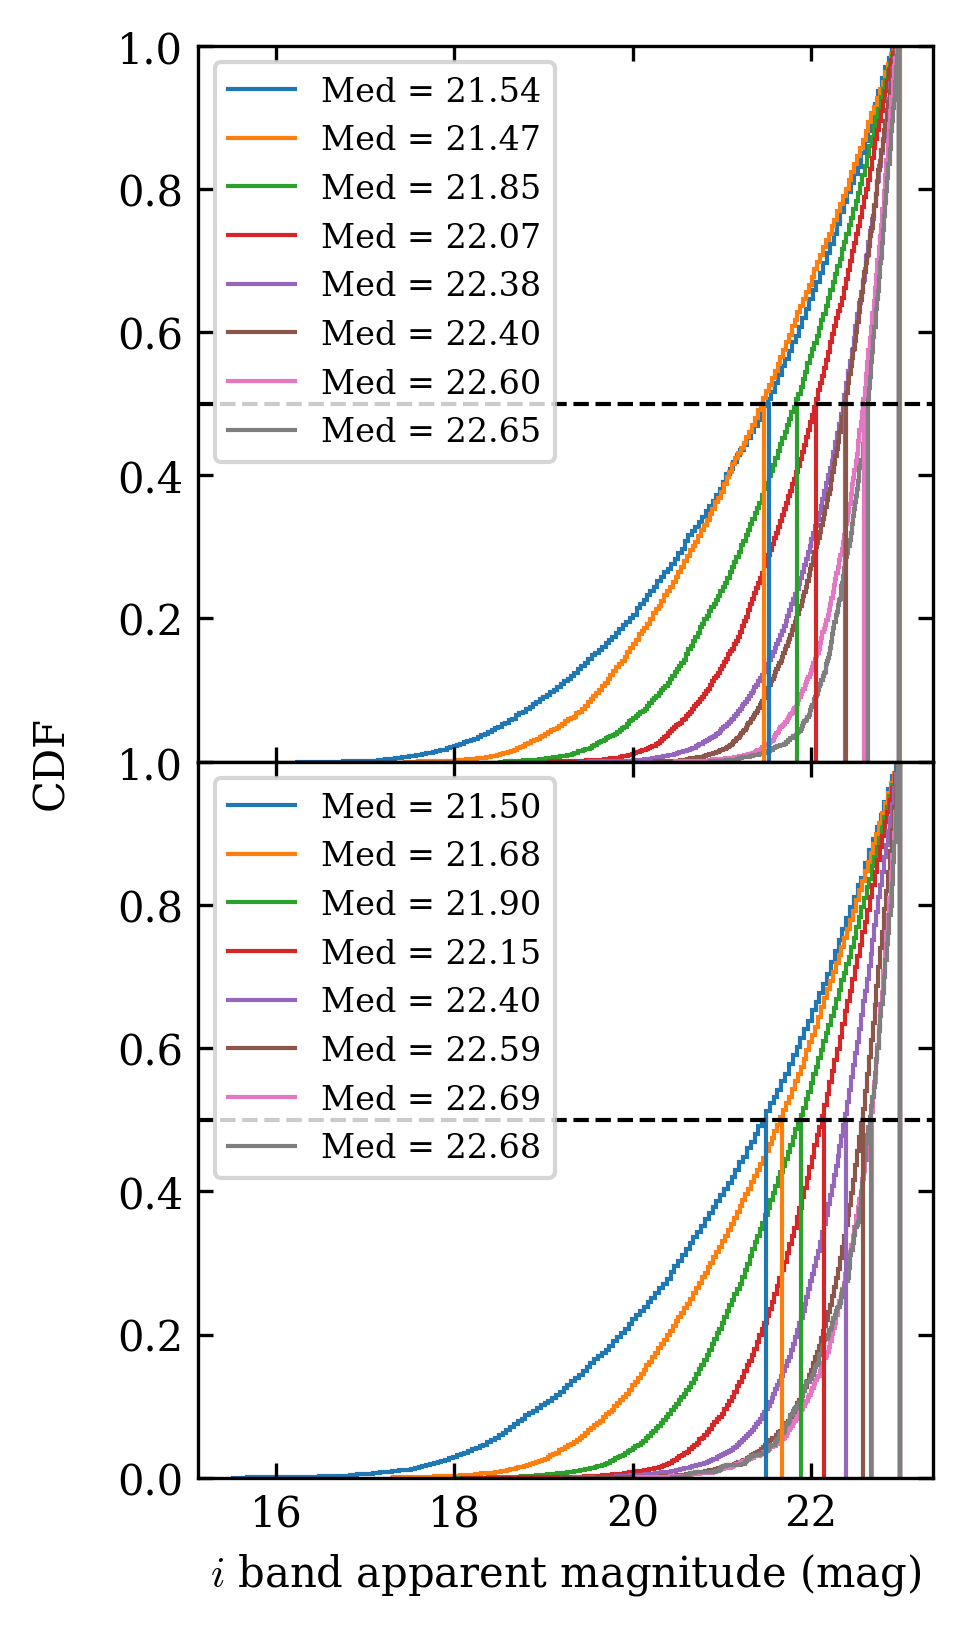

In [11]:
factor = latex_textwidth/72*0.5
fig = plt.figure(figsize=(1*factor,2*factor),dpi=300)
ax1 = plt.subplot(211)
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

increments = np.linspace(90,150,len(bins))
for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)
    
#     lamb_sample = band_obsframe[truth_table].flatten()
    
    iband_mags = data_sample.loc[truth_table,'i_auto']
    N_objects = iband_mags.size
    median = np.median(iband_mags)
#     digitized = np.digitize(lamb_sample,band_bins)
#     binned_means = [np.nanmedian(iband_mags[digitized == i]) for i in range(1,len(band_bins))]
    hist = plt.hist(iband_mags,175,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
#     plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
#                 label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='Med = {:4.2f}'.format(median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
# plt.xlabel('$i$ band apparent magnitude (mag)')
# plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend(fontsize=8)
# custom_SAVEFIG('PAUS_CDF')
# plt.show()
# locs, labels = plt.xticks()
plt.yticks(plt.yticks()[0][1:])
    
ax2 = plt.subplot(212,sharex=ax1)

imags = np.array(LC_DATA_CORE['Data/appMio_tot_ext'])
zs = np.array(LC_DATA_CORE['Data/z_obs'])
LC_ras = np.array(LC_DATA_CORE['Data/ra'])
LC_decs = np.array(LC_DATA_CORE['Data/dec'])

mask = (imags<23) & (LC_ras < np.median(LC_ras)+1) & (LC_ras > np.median(LC_ras)-1) & (LC_decs < np.median(LC_decs)+0.5) & (LC_decs > np.median(LC_decs)-0.5)

zs = zs[mask]
imags = imags[mask]

# print(zs.min(),zs.max())

# plt.figure(figsize=(1*factor,1*factor),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

for ind,z_bin in enumerate(bins):
    
    truth_table = (zs >= z_bin[0]) & (zs <= z_bin[1]) 
    
    iband_mags = imags[truth_table]
    N_objects = iband_mags.size
    median = np.median(iband_mags)

    hist = plt.hist(iband_mags,175,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
#     plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
#                 label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='Med = {:4.2f}'.format(median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
plt.xlabel('$i$ band apparent magnitude (mag)')
# plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend(loc='upper left',fontsize=8)

# custom_SAVEFIG('MOCK_SUBSECTION_CDF')
fig.subplots_adjust(hspace=0)
plt.text(-0.2,0,'CDF',horizontalalignment='center',\
          verticalalignment='center', transform=ax1.transAxes,rotation='vertical',fontsize=10)
custom_SAVEFIG('CDF_COMBINED_PAUS_MOCK')
plt.show()

# Summary imag against z

Save figure? (y/n)


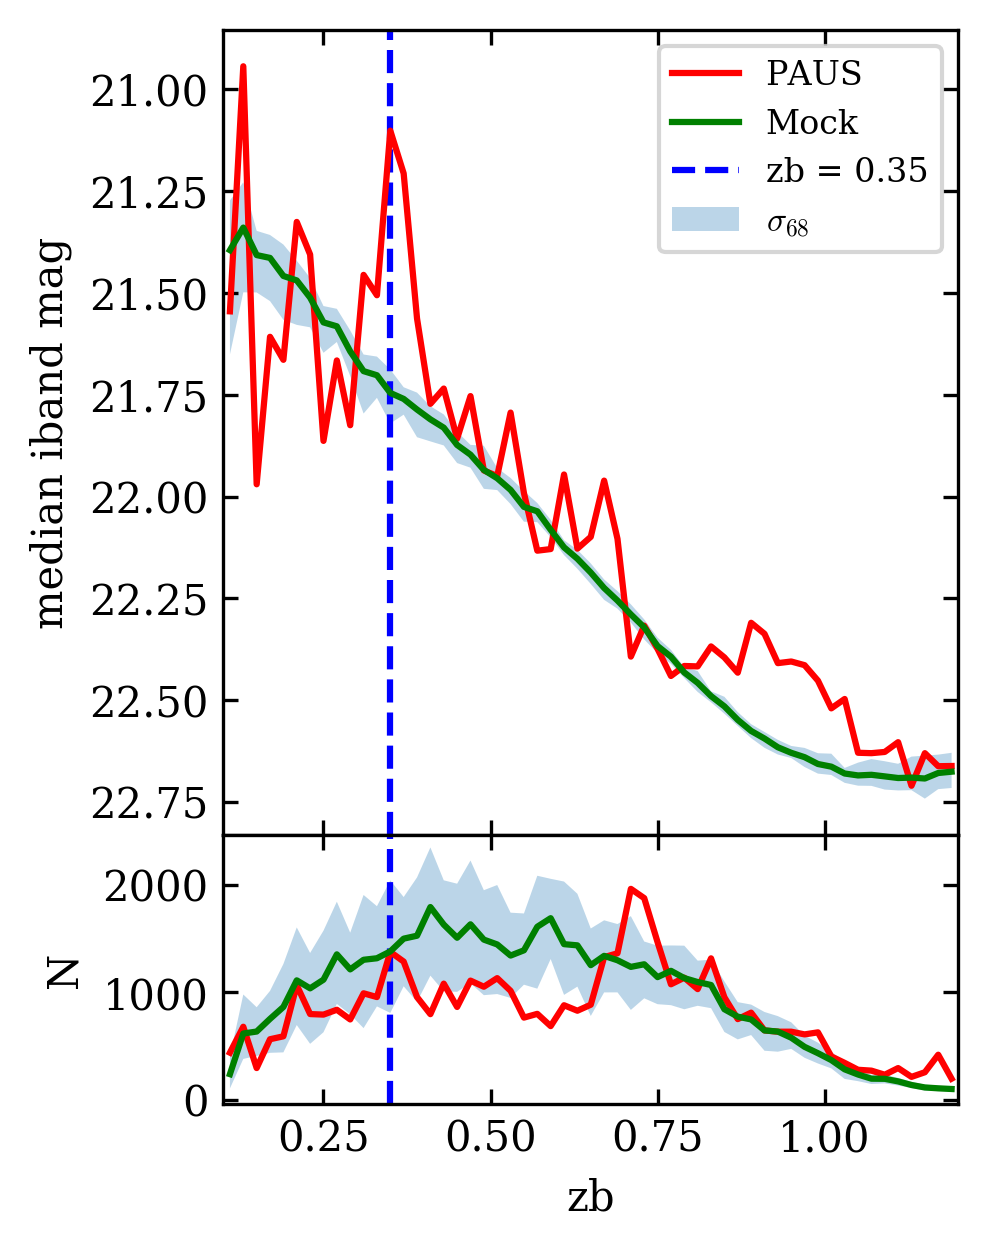

In [17]:
factor = latex_textwidth/72*0.5
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.5*factor),dpi=300,sharex=True)


# ax = plt.subplot(331+i)
bins = []
bin_range = [0.1,1.2]
#     print(bin_range)

bin_increment = 0.02
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

LC_zs = np.array(LC_DATA_CORE['Data/z_cos'])
LC_imags = np.array(LC_DATA_PHOTOM['Data/appOio_tot_ext'])
LC_ras = np.array(LC_DATA_CORE['Data/ra'])
LC_decs = np.array(LC_DATA_CORE['Data/dec'])

#CUT
mag_cut = 23
mask = LC_imags < mag_cut
# LC_zs, LC_imags = LC_zs[mask], LC_imags[mask]
    

RA_incs = range(129,142,2)
DEC_incs = range(-2,4,1)
RA_list, DEC_list = [], []

for i in range(len(RA_incs)-1):
    RA_list.append([RA_incs[i],RA_incs[i+1]])

for i in range(len(DEC_incs)-1):
    DEC_list.append([DEC_incs[i],DEC_incs[i+1]])

median_imags_PA,bins,dig_P = scipy.stats.binned_statistic(data_sample['zb'],data_sample['i_auto'],'median',temp_bins)
unique, counts_P = np.unique(dig_P,return_counts=True)

median_imags_LC,bins, dig_L = scipy.stats.binned_statistic(LC_zs[mask],LC_imags[mask],'median',temp_bins)



mid_zbins = (temp_bins[1:]+temp_bins[:-1])/2
median_imag_LC_segments = []
counts_segs = []

for ra_bin in RA_list:
#     print(ra_bin)
    for dec_bin in DEC_list:
#         print(dec_bin)
        mask = (LC_ras > ra_bin[0]) & (LC_ras < ra_bin[1]) & (LC_decs > dec_bin[0]) & (LC_decs < dec_bin[1]) & (LC_imags < mag_cut) & (LC_zs <= 1.2)
        zs_temp, imags_temp = LC_zs[mask], LC_imags[mask]
#         print(mask.sum())
        medians, bins, digs =  scipy.stats.binned_statistic(zs_temp,imags_temp,'median',temp_bins)
        
        median_imag_LC_segments.append(medians)
        unique, counts = np.unique(digs,return_counts=True)
#         print(bins.size,unique.size)
        counts_segs.append(counts)
        
#         print(median_imag_LC_segment)
#         plt.plot(mid_zbins,median_imag_LC_segment,'--')

# np.savetxt('test1.txt',digs)
# np.savetxt('test4.txt',zs_temp)
# np.savetxt('test2.txt',bins)
# np.savetxt('test3.txt',dig_P)

counts_segs_ = counts_segs[0]
counts_segs_ = np.concatenate((counts_segs_[None,:],counts_segs[1][None,:]),axis=0)

for i in range(len(counts_segs)-2):
    counts_segs_ = np.concatenate((counts_segs_,counts_segs[i+2][None,:]),axis=0)
# print(counts_segs_.shape)


median_imag_LC_segments = np.array(median_imag_LC_segments)
lb68 = np.percentile(median_imag_LC_segments,50-34.1,axis=0)
ub68 = np.percentile(median_imag_LC_segments,50+34.1,axis=0)

lb_counts = np.percentile(counts_segs_[:,1:],50-34.1,axis=0)
ub_counts = np.percentile(counts_segs_[:,1:],50+34.1,axis=0)

# for i in range(median_imag_LC_segments.shape[0]):
#     ax1.plot(mid_zbins,median_imag_LC_segments[i])

ax1.plot(mid_zbins,median_imags_PA,'r-',label='PAUS')
ax1.plot(mid_zbins,median_imags_LC,color='green',label='Mock')
ax1.fill_between(mid_zbins,lb68,ub68,alpha=0.3,label=r'$\sigma_{68}$')
# ax1.legend()
ax2.set_xlabel('zb')
ax1.set_xlim([0.1,1.2])
ax1.set_ylabel('median iband mag')
ax2.plot(mid_zbins,counts_P[1:],'r-',label='PAUS')
ax2.plot(mid_zbins,counts_segs_[:,1:].mean(axis=0),'g-',label='Mean across Mock segments')
ax2.fill_between(mid_zbins,lb_counts,ub_counts,alpha=0.3,zorder=1,label='$\omega_{68}$')
# ax2.legend(fontsize=8)
ax2.set_ylabel('N')

redshiftdip = 0.35
ax1.axvline(redshiftdip,linestyle='--',color='blue',zorder=1,label='zb = {}'.format(redshiftdip))
ax2.axvline(redshiftdip,linestyle='--',color='blue',zorder=1)
ax1.invert_yaxis()

ax1.legend(fontsize=8)
# print(counts_segs_[:,1:].mean(axis=0),'\n',counts_P[1:])
fig.subplots_adjust(hspace=0)
custom_SAVEFIG('MEDIAN_i_BAND')
plt.show()


In [15]:
# LC_DATA_PHOTOM.visit(lambda x: print(x))